In [10]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
import rasterio
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

##### Find the weighted average distance to nearest dam for all cropland

In [3]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)
gdf_dams = gdf_dams.set_crs("EPSG:3857")  # Ensure the initial CRS is correct

# Load arid cropland tif
arid_cropland_tif_path = resolve_path(config['Arid_Cropland_tif_path'])
with rasterio.open(arid_cropland_tif_path) as src:
    cropland_data = src.read(1)
    cropland_transform = src.transform
    cropland_crs = src.crs

    # Reproject cropland data to EPSG:3857
    target_crs = 'EPSG:3857'
    if cropland_crs != target_crs:
        dst_transform, width, height = calculate_default_transform(
            cropland_crs, target_crs, src.width, src.height, *src.bounds)
        destination = np.empty((height, width), dtype=cropland_data.dtype)
        reproject(
            source = cropland_data,
            destination = destination,
            src_transform = cropland_transform,
            src_crs=cropland_crs,
            dst_transform = dst_transform,
            dst_crs=target_crs,
            resampling = Resampling.nearest
        )
        cropland_data = destination
        cropland_transform = dst_transform
        cropland_crs = target_crs

print(cropland_crs)

# Function to find distance to nearest dam
def nearest_dam_distance(point, dams):
    distances = dams.distance(point)
    return distances.min()

# Initialize variables for weighted average
weighted_distance_sum = 0
weight_sum = 0

# Extract the coordinates and values of cropland pixels
rows, cols = np.nonzero(cropland_data > 0)
cropland_values = cropland_data[rows, cols]

# Convert pixel coordinates to geographical coords
coordinates = [Point(cropland_transform * (col,row)) for row, col in zip(rows, cols)]

# Calulate distances and accumulate weighted sums
for i, (point, value) in tqdm(enumerate(zip(coordinates, cropland_values)), total = len(coordinates)):
    distance = nearest_dam_distance(point, gdf_dams)
    weighted_distance_sum += distance * value
    weight_sum += value

# Calculate weighted average distance
if weight_sum > 0:
    weighted_avg_distance = weighted_distance_sum / weight_sum
    print(f"Weighted Average Distance to Nearest Dam: {weighted_avg_distance / 1000} kilometers")
else:
    print("No valid cropland pixels found.")

# Close
src.close()

EPSG:3857


100%|██████████| 92895/92895 [00:43<00:00, 2124.77it/s]

Weighted Average Distance to Nearest Dam: 3265.884553564966 meters


##### Compute the average distance from CPIS to the nearest dam

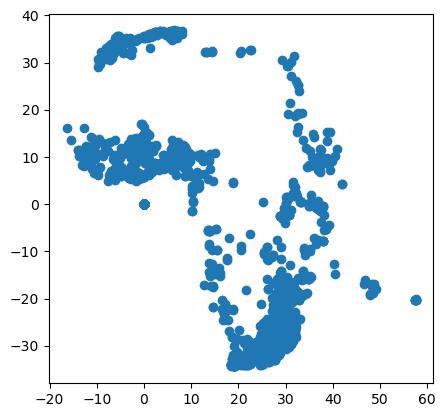

Average Distance to Nearest Dam (CPIS): 4220.502742069371 kilometers
count    3.236400e+04
mean     4.220503e+06
std      4.095670e+05
min      1.153010e+06
25%      4.133060e+06
50%      4.293382e+06
75%      4.419583e+06
max      5.465848e+06
Name: nearest_dam_distance, dtype: float64


In [6]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)

gdf_dams.plot()
plt.show()

# Load the CPIS shapefile
gdf_cpis = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))

# Ensure both GeoDataFrames use the same CRS (unit in meters instead of degrees)
gdf_dams = gdf_dams.set_crs("EPSG:3857")
gdf_cpis = gdf_cpis.to_crs("EPSG:3857")

# Calculate distances from each CPIS to the nearest dam
gdf_cpis['nearest_dam_distance'] = gdf_cpis.geometry.apply(lambda x: gdf_dams.distance(x).min())

# Calculate average distance from CPIS to nearest dam
average_distance_cpis = (gdf_cpis['nearest_dam_distance']/1000).mean()
print(f"Average Distance to Nearest Dam (CPIS): {average_distance_cpis / 1000} kilometers")


In [13]:
average_distance_cpis = (gdf_cpis['nearest_dam_distance']/1000).mean()
average_distance_cpis.describe()

AttributeError: 'numpy.float64' object has no attribute 'describe'

In [8]:
# Calculate the targeting ratio
targeting_ratio = weighted_avg_distance / average_distance_cpis
print(f"Targeting Ratio: {targeting_ratio}")

Targeting Ratio: 0.773814105369745


100%|██████████| 92895/92895 [00:49<00:00, 1885.31it/s]


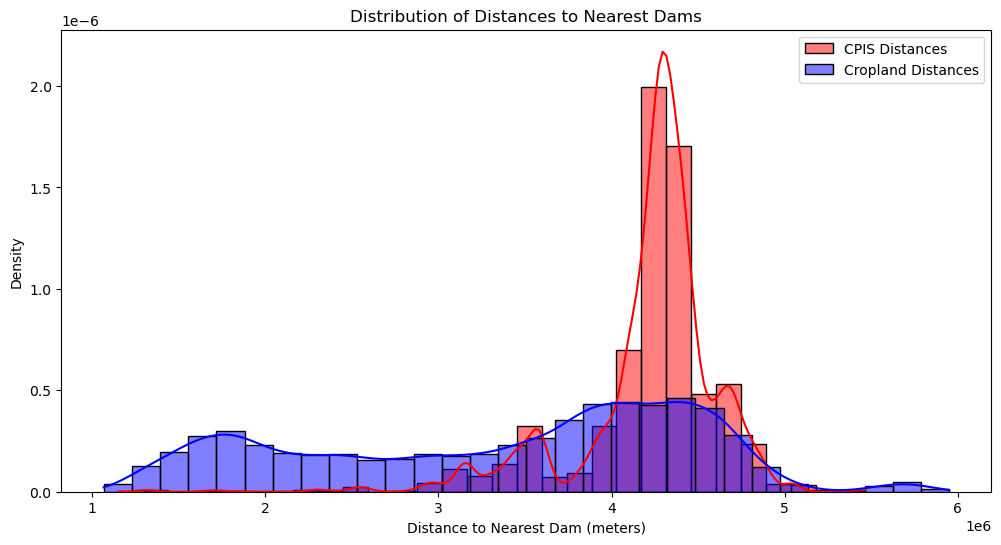

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate distances and accumulate weighted sums for cropland
cropland_distances = []
for i, (point, value) in tqdm(enumerate(zip(coordinates, cropland_values)), total=len(coordinates)):
    distance = nearest_dam_distance(point, gdf_dams)
    if value > 0:  # Ensure that we only include cropland pixels that are effectively cropland
        cropland_distances.append(distance)

# Plotting
plt.figure(figsize=(12, 6))

# Plot histogram of CPIS distances
sns.histplot(gdf_cpis['nearest_dam_distance'], color="red", label='CPIS Distances', kde=True, stat="density", bins=30)

# Plot histogram of Cropland distances
sns.histplot(cropland_distances, color="blue", label='Cropland Distances', kde=True, stat="density", bins=30)

plt.title('Distribution of Distances to Nearest Dams')
plt.xlabel('Distance to Nearest Dam (meters)')
plt.ylabel('Density')
plt.legend()
plt.show()


100%|██████████| 92895/92895 [00:48<00:00, 1932.62it/s]


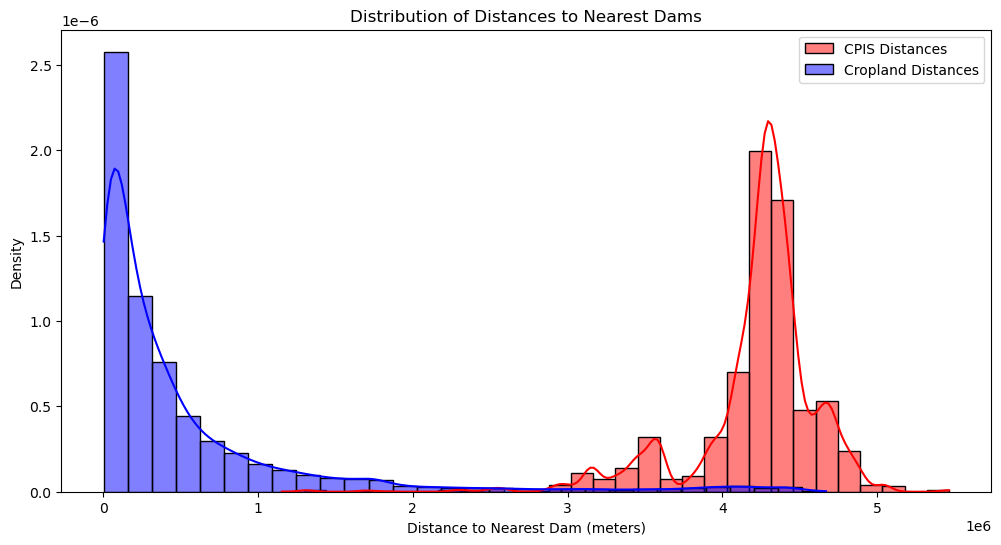

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate distances and accumulate weighted sums for cropland
cropland_weighted_distances = []
for i, (point, value) in tqdm(enumerate(zip(coordinates, cropland_values)), total=len(coordinates)):
    distance = nearest_dam_distance(point, gdf_dams)
    if value > 0:  # Ensure that we only include cropland pixels that are effectively cropland
        cropland_weighted_distances.append(distance * value)

# Plotting
plt.figure(figsize=(12, 6))

# Plot histogram of CPIS distances
sns.histplot(gdf_cpis['nearest_dam_distance'], color="red", label='CPIS Distances', kde=True, stat="density", bins=30)

# Plot histogram of Cropland distances
sns.histplot(cropland_weighted_distances, color="blue", label='Cropland Distances', kde=True, stat="density", bins=30)

plt.title('Distribution of Distances to Nearest Dams')
plt.xlabel('Distance to Nearest Dam (meters)')
plt.ylabel('Density')
plt.legend()
plt.show()
